# Model Evaluation and Validation

In this notebook, we will learn how to:
- Split data properly for training/testing
- Measure accuracy, precision, recall, and F1-score
- Use confusion matrices and ROC curves
- Perform k-fold cross-validation
- Compare different models fairly


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [2]:
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (105, 4)
Test shape: (45, 4)


In [3]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.3f}")


Logistic Regression Accuracy: 0.933
Decision Tree Accuracy: 0.933
Random Forest Accuracy: 0.889
SVM Accuracy: 0.956


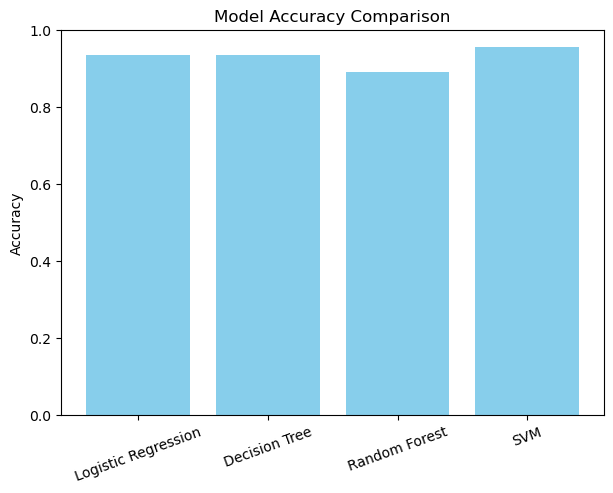

In [4]:
plt.figure(figsize=(7,5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.ylim(0,1)
plt.show()


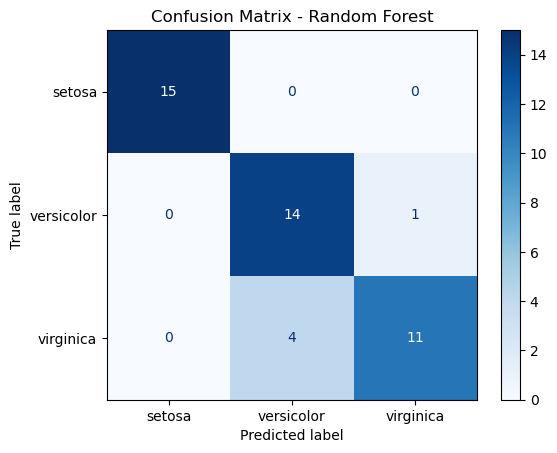

In [5]:
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [6]:
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))


Classification Report for Random Forest:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.78      0.93      0.85        15
   virginica       0.92      0.73      0.81        15

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45



In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")


Logistic Regression: 0.967 ± 0.030
Decision Tree: 0.953 ± 0.034
Random Forest: 0.947 ± 0.027
SVM: 0.967 ± 0.030


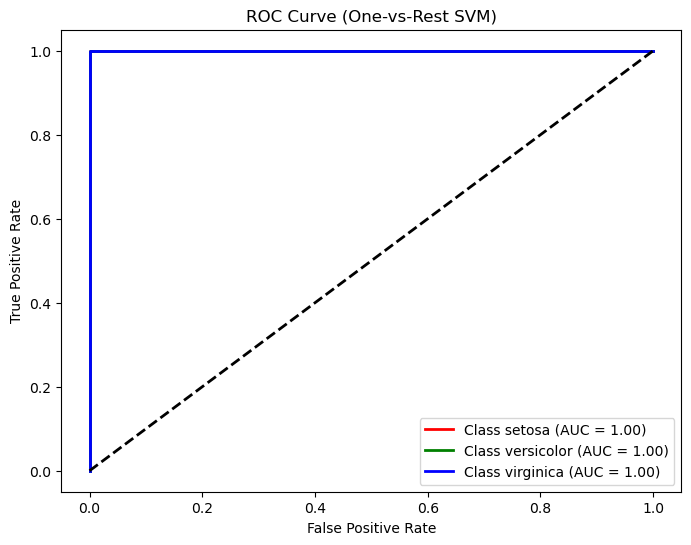

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# Binarize labels for ROC curve plotting
y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Use OneVsRestClassifier for multi-class ROC
model = OneVsRestClassifier(SVC(probability=True, random_state=42))
model.fit(X_train, y_train)

# Predict probabilities for ROC curve
y_score = model.decision_function(X_test)

# Binarize y_test for ROC calculation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {iris.target_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest SVM)")
plt.legend(loc="lower right")
plt.show()


## 🧾 Common Evaluation Metrics

| Metric | Type | Description |
|---------|------|-------------|
| **Accuracy** | Classification | % of correct predictions |
| **Precision** | Classification | How many predicted positives are correct |
| **Recall (Sensitivity)** | Classification | How many actual positives are detected |
| **F1-score** | Classification | Harmonic mean of precision & recall |
| **ROC AUC** | Binary Classification | Area under ROC curve |
| **Cross-Validation** | General | Reliable accuracy across multiple splits |

---

### ⚖️ Key Ideas
- Always evaluate models on **unseen data**
- Use **cross-validation** to avoid lucky test splits
- Look beyond accuracy — check **precision, recall, F1**
- Use **ROC/AUC** for imbalanced datasets
